# Problem Statement - Predict Customer Lifetime Value (CLV) to identify high-value customers and optimize business strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Load dataset
df = pd.read_excel("/content/online_retail_II.xlsx")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# Check missing values
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,2928
Quantity,0
InvoiceDate,0
Price,0
Customer ID,107927
Country,0


In [5]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['Customer ID'])

In [6]:
# Remove Duplicate values
df = df.drop_duplicates()

In [13]:
# Convert InvoiceDate to Date format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Exploratory Data Analysis

<ipython-input-15-60443034a438>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


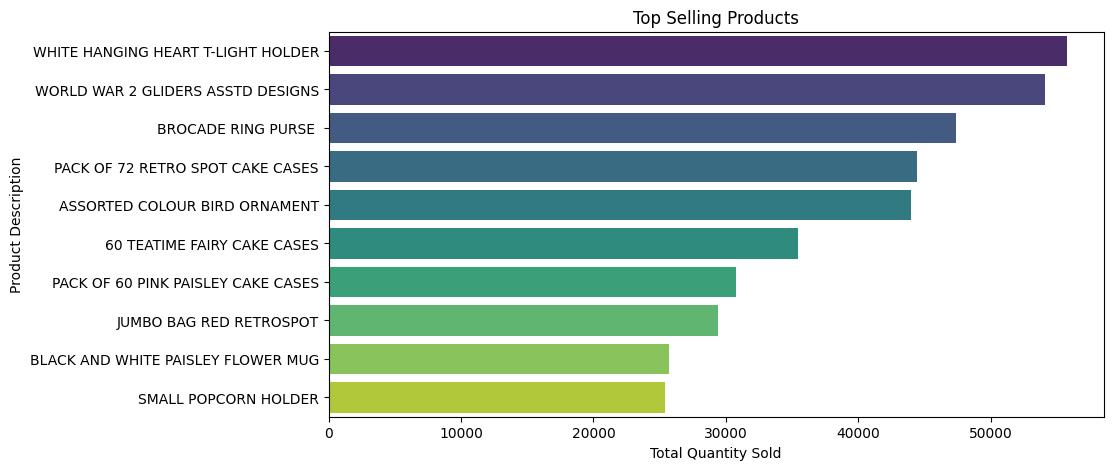

In [15]:
# Check Top Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()

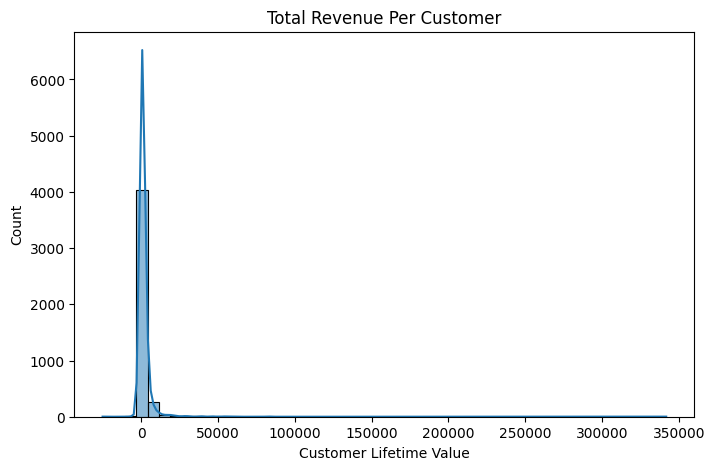

In [20]:
# Total Revenue Per Customer
df['TotalRevenue'] = df['Quantity'] * df['Price']
customer_revenue = df.groupby('Customer ID')['TotalRevenue'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.histplot(customer_revenue['TotalRevenue'], bins=50, kde=True)
plt.title("Total Revenue Per Customer")
plt.xlabel("Customer Lifetime Value")
plt.show()

In [23]:
# Feature Engineering
# Get most recent date in dataset
latest_date = df['InvoiceDate'].max()

# Calculate Recency, Frequency, and Monetary
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, # Recency
    'Invoice': 'nunique', # Frequency
    'TotalRevenue': 'sum' # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,66,15,-51.74
1,12347.0,2,2,1323.32
2,12348.0,73,1,222.16
3,12349.0,42,4,2646.99
4,12351.0,10,1,300.93


In [24]:
# Prepare Data for Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# Apply Random Forest Model on dataset

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R2 Score: {r2_score(y_test, y_pred_rf)}")

MAE: 1339.9831551085526
RMSE: 6801.4957340894725
R2 Score: 0.5028906180855379


In [29]:
# Hyperparameter Tuning Using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 150}
Best R2 Score: 0.13829009640291517
